In [1]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn
import joblib
from torch.utils.data import Dataset, DataLoader
import time
import torch.nn.functional as F

In [2]:
# Preset parameters
RANDOM_SEED = 42
VALIDATE_SIZE = 0.2

In [3]:
# Setting random seeds to ensure reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

In [2]:
# Patient file paths
patients = {
    1: ['Data/organized_fcs_data1a.csv', 'Data/organized_fcs_data1b.csv', 'Data/organized_fcs_data1c.csv'],
    2: ['Data/organized_fcs_data2a.csv', 'Data/organized_fcs_data2b.csv', 'Data/organized_fcs_data2c.csv'],
    3: ['Data/organized_fcs_data3a.csv', 'Data/organized_fcs_data3b.csv', 'Data/organized_fcs_data3c.csv'],
    4: ['Data/organized_fcs_data4a.csv', 'Data/organized_fcs_data4b.csv', 'Data/organized_fcs_data4c.csv'],
    5: ['Data/organized_fcs_data5a.csv', 'Data/organized_fcs_data5b.csv', 'Data/organized_fcs_data5c.csv'],
    6: ['Data/organized_fcs_data6a.csv', 'Data/organized_fcs_data6b.csv', 'Data/organized_fcs_data6c.csv'],
    7: ['Data/organized_fcs_data7.csv'],
    8: ['Data/organized_fcs_data8a.csv', 'Data/organized_fcs_data8b.csv', 'Data/organized_fcs_data8c.csv'],
    9: ['Data/organized_fcs_data9a.csv', 'Data/organized_fcs_data9b.csv'],
    10: ['Data/organized_fcs_data10a.csv', 'Data/organized_fcs_data10b.csv', 'Data/organized_fcs_data10c.csv'],
    11: ['Data/organized_fcs_data11.csv'],
    12: ['Data/organized_fcs_data12a.csv', 'Data/organized_fcs_data12b.csv', 'Data/organized_fcs_data12c.csv']
}

In [3]:
training_dfs = []
testing_dfs = []

first_six_ids = [1, 2, 3, 4, 5, 6]
training_ids = [1,2,3,4,5]     

for patient_id, file_paths in patients.items():
    patient_data = pd.concat([pd.read_csv(file).drop(columns=['Time'], errors='ignore') for file in file_paths])
    
    if patient_id in training_ids:
        training_dfs.append(patient_data)
    if patient_id not in training_ids and patient_id in first_six_ids:
        testing_dfs.append(patient_data)

train_full = pd.concat(training_dfs, ignore_index=True)
test_full = pd.concat(testing_dfs, ignore_index=True)

In [90]:
print(training_ids)

[1, 2, 3, 4, 5]


In [41]:
print(f"Training data samples: {len(training_dfs)}")
print(f"Testing data samples: {len(testing_dfs)}")

Training data samples: 5
Testing data samples: 1


In [91]:
pipeline = Pipeline([('scaler', MinMaxScaler())])
pipeline.fit(train_full)

Pipeline(steps=[('scaler', MinMaxScaler())])

In [92]:
# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(train_full)
X_validate_transformed = pipeline.transform(test_full)

In [93]:
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

In [28]:
print(input_dim)

14


In [45]:
class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset = torch.tensor(dataset, dtype=torch.float32)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]

In [94]:
train_dataset = CustomDataset(X_train_transformed)
val_dataset = CustomDataset(X_validate_transformed)

In [95]:
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE, shuffle=False)

In [32]:
class VarAutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=4):
        super().__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ELU(),
            nn.Linear(16, 8),
            nn.ELU(),
            nn.Linear(8, 4),
            nn.ELU(),
        )

        self.fc_mu = nn.Linear(4, latent_dim)
        self.fc_log_var = nn.Linear(4, latent_dim)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 4),
            nn.ELU(),
            nn.Linear(4, 8),
            nn.ELU(),
            nn.Linear(8, 16),
            nn.ELU(),
            nn.Linear(16, input_dim),
            nn.ELU()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        log_var = self.fc_log_var(encoded)
        z = self.reparameterize(mu, log_var)
        decoded = self.decoder(z)
        return decoded, mu, log_var

In [48]:
autoencoder= VarAutoEncoder(input_dim=input_dim)
print(autoencoder)

VarAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=14, out_features=16, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ELU(alpha=1.0)
  )
  (fc_mu): Linear(in_features=4, out_features=4, bias=True)
  (fc_log_var): Linear(in_features=4, out_features=4, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=4, out_features=8, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=8, out_features=16, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=16, out_features=14, bias=True)
    (7): ELU(alpha=1.0)
  )
)


In [35]:
def vae_loss_function(reconstructed, original, mu, log_var, beta=0.005):
    recon_loss = F.mse_loss(reconstructed, original, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + beta * kl_loss

In [36]:
def train_autoencoder(model, train_loader, val_loader, epochs=100, lr=0.001):
    device = torch.device('cpu')
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 15
    patience_counter = 0
    
    print(f"Training Variational Autoencoder for {epochs} epochs...")
    print("-" * 50)
    
    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        train_loss = 0.0
        for batch_data in train_loader:
            batch_data = batch_data.to(device)
            optimizer.zero_grad()
            reconstructed, mu, log_var = model(batch_data)
            loss = vae_loss_function(reconstructed, batch_data, mu, log_var, beta=0.005)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_data in val_loader:
                batch_data = batch_data.to(device)
                reconstructed, mu, log_var = model(batch_data)
                loss = vae_loss_function(reconstructed, batch_data, mu, log_var, beta=0.005)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model = model.state_dict().copy()
        else:
            patience_counter += 1
        
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1:3d}/{epochs} | Train: {avg_train_loss:.6f} | Val: {avg_val_loss:.6f} | Time: {epoch_time:.1f}s | Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            print(f"Best validation loss: {best_val_loss:.6f}")
            model.load_state_dict(best_model)
            break

    print("Training completed!")
    return model, train_losses, val_losses

In [96]:
def run_training():
    vae = autoencoder
    print(f"Model created with {sum(p.numel() for p in vae.parameters())} parameters")
    trained_model, train_history, val_history = train_autoencoder(
        model=vae,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=EPOCHS,
        lr=0.001
    ) 
    return trained_model, train_history, val_history

if __name__ == "__main__":
    trained_model, train_losses, val_losses = run_training()

Model created with 894 parameters
Training Variational Autoencoder for 100 epochs...
--------------------------------------------------
Epoch   1/100 | Train: 0.007754 | Val: 0.007772 | Time: 112.2s | Patience: 0/15
Epoch   2/100 | Train: 0.007753 | Val: 0.007673 | Time: 106.6s | Patience: 0/15
Epoch   3/100 | Train: 0.007748 | Val: 0.007785 | Time: 104.0s | Patience: 1/15
Epoch   4/100 | Train: 0.007752 | Val: 0.007686 | Time: 102.7s | Patience: 2/15
Epoch   5/100 | Train: 0.007749 | Val: 0.007688 | Time: 103.7s | Patience: 3/15
Epoch   6/100 | Train: 0.007746 | Val: 0.007731 | Time: 105.5s | Patience: 4/15
Epoch   7/100 | Train: 0.007745 | Val: 0.007739 | Time: 105.8s | Patience: 5/15
Epoch   8/100 | Train: 0.007749 | Val: 0.007709 | Time: 103.5s | Patience: 6/15
Epoch   9/100 | Train: 0.007749 | Val: 0.007699 | Time: 108.6s | Patience: 7/15
Epoch  10/100 | Train: 0.007748 | Val: 0.007753 | Time: 106.5s | Patience: 8/15
Epoch  11/100 | Train: 0.007741 | Val: 0.007722 | Time: 109.6s |

In [ ]:
#Saving Only the model weights
torch.save(trained_model.state_dict(), 'vae_4dim_6_final.pth')

In [ ]:
# Loading the model weights
loaded_model = VarAutoEncoder(input_dim=input_dim, latent_dim=4)
loaded_model.load_state_dict(torch.load("vae_4dim_6_final.pth"))
loaded_model.eval()

VarAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=14, out_features=16, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ELU(alpha=1.0)
  )
  (fc_mu): Linear(in_features=4, out_features=4, bias=True)
  (fc_log_var): Linear(in_features=4, out_features=4, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=4, out_features=8, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=8, out_features=16, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=16, out_features=14, bias=True)
    (7): ELU(alpha=1.0)
  )
)

In [98]:
def test_autoencoder_on_patient(patient_id, model, pipeline, patients_dict):
    file_paths = patients_dict[patient_id]
    patient_df = pd.concat([pd.read_csv(fp).drop(columns=['Time'], errors='ignore') for fp in file_paths], ignore_index=True)
    patient_data_transformed = pipeline.transform(patient_df)
    patient_tensor = torch.tensor(patient_data_transformed, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        reconstructed, _, _ = model(patient_tensor)
        reconstructed = reconstructed.numpy()
    mse = np.mean((patient_data_transformed - reconstructed) ** 2, axis=1)
    return mse


In [ ]:
pt1 = test_autoencoder_on_patient(6, loaded_model, pipeline, patients)
print(pt1)

[0.00609964 0.01937557 0.00548777 ... 0.00789891 0.00413183 0.00332375]


In [ ]:
#MSE --> 0.3466
#MAE --> 0.4233

#      Predicted      Actual.     Reconstruction Error
# 7    3.40%          3.28%         0.02336
# 8    1.20%          1.2%          0.02319
# 9    9.19%          9.3%          0.02288
# 10   2.63%          2.17%         0.02565
# 11   13.42%         14.6%         0.02216
# 12   3.53%          4.2%          0.02141

#Avg threshold = 0.02310833333333333

# For Healthy 
# patient 1 --> 0.94%
# patient 2 --> 0.53%
# patient 3 --> 0.76%
# patient 4 --> 1.35%
# patient 5 --> 0.23%
# patient 6 --> 0.75%

In [110]:
percent_unhealthy = 4.2
threshold_index = int((percent_unhealthy / 100) * len(pt1))
threshold_value = np.sort(pt1)[-threshold_index]

print(f"Threshold for top {percent_unhealthy}% reconstruction errors: {threshold_value:.5f}")

Threshold for top 4.2% reconstruction errors: 0.02141


In [111]:
print((0.02336+0.02319+0.02288+0.02565+0.02216+0.02141)/6)

0.02310833333333333


In [134]:
threshold = 0.02310833333333333

# Calculate percentage above threshold
num_above = np.sum(pt1 > threshold)
total = len(pt1)
percent_above = (num_above / total) * 100

print(f"{percent_above:.2f}% of cells have reconstruction error > {threshold}")

0.75% of cells have reconstruction error > 0.02310833333333333


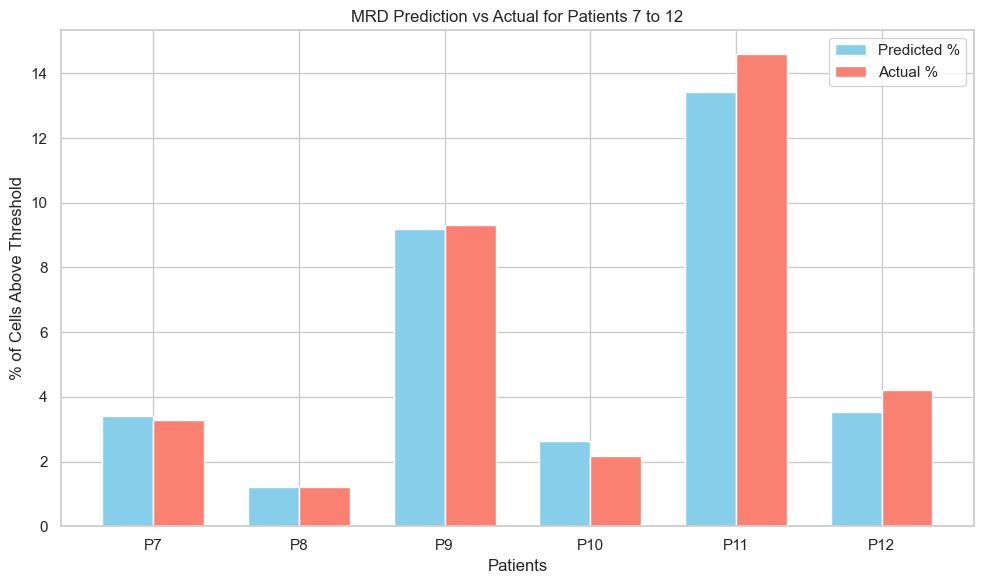

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Patient IDs
patients = ['P7', 'P8', 'P9', 'P10', 'P11', 'P12']

# Predicted percentages by model
predicted_percentages = [3.40,1.20,9.19,2.63,13.42,3.53]  
# Actual percentages
actual_percentages = [3.28, 1.2, 9.3, 2.17, 14.6, 4.2]

# DataFrame for visualization
df_plot = pd.DataFrame({
    'Patient': patients,
    'Predicted': predicted_percentages,
    'Actual': actual_percentages
})

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot bars
bar_width = 0.35
x = np.arange(len(patients))
plt.bar(x - bar_width/2, df_plot['Predicted'], bar_width, label='Predicted %', color='skyblue')
plt.bar(x + bar_width/2, df_plot['Actual'], bar_width, label='Actual %', color='salmon')

# labels and legend
plt.xlabel('Patients')
plt.ylabel('% of Cells Above Threshold')
plt.title('MRD Prediction vs Actual for Patients 7 to 12')
plt.xticks(ticks=x, labels=patients)
plt.legend()
plt.tight_layout()
plt.show()


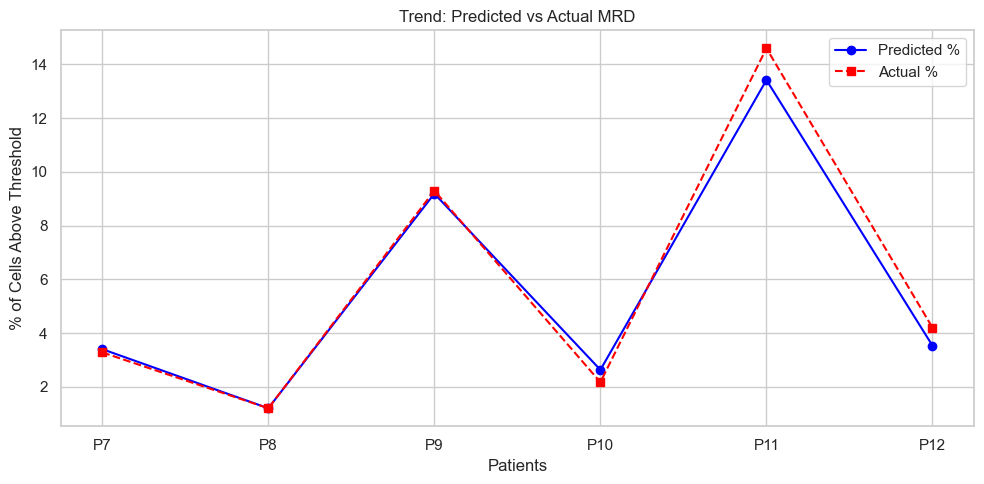

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(patients, predicted_percentages, marker='o', label='Predicted %', linestyle='-', color='blue')
plt.plot(patients, actual_percentages, marker='s', label='Actual %', linestyle='--', color='red')

plt.xlabel('Patients')
plt.ylabel('% of Cells Above Threshold')
plt.title('Trend: Predicted vs Actual MRD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()